# Ranking SP occurences for Exploration

We aim to use the detection algorithm in order to guide a user in data exploration, so we need to decide a ranking to present them.  



In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn.feature_selection as feat_sel

import detect_simpsons_paradox as dsp
import sp_data_util as spdata
from sp_data_util import sp_plot
import itertools as itert

First, we need to sample data that has SP.

In [2]:
r_clusters = -.9  # correlation coefficient of clusters
cluster_spread = [.6,.8,.5] # pearson correlation of means
p_sp_clusters = .75 # portion of clusters with SP 
k = [3, 2,5] # number of clusters
cluster_size = [7,1]
domain_range = [0, 20, 0, 20]
N = 200 # number of points
p_clusters =  [[1.0/k_i]*k_i for k_i in k] 
n_views = 3

many_sp_df_diff = spdata.geometric_indep_views_gmm_sp(n_views,r_clusters,cluster_size,cluster_spread,p_sp_clusters,
                domain_range,k,N,p_clusters)

sp_design_list = [('x1','x2','A'),('x3','x4','B'), ('x5','x6','C')]
many_sp_df_diff.head()

200
6


,x1,x2,x3,x4,x5,x6,A,B,C
0,7.585484,6.562077,12.703916,12.453111,5.424829,6.486822,A2,B0,C3
1,13.323779,14.807015,14.358890,13.790275,6.725507,13.250069,A0,B0,C2
2,11.648648,9.787529,7.004149,11.920667,10.948740,13.803093,A1,B1,C0
3,12.021082,17.254041,5.910205,13.039731,10.531477,10.309307,A0,B1,C1
4,6.585876,8.075560,13.990696,13.640408,3.725090,8.056957,A2,B0,C3


We'll also plot them in the dimensions where we added SP

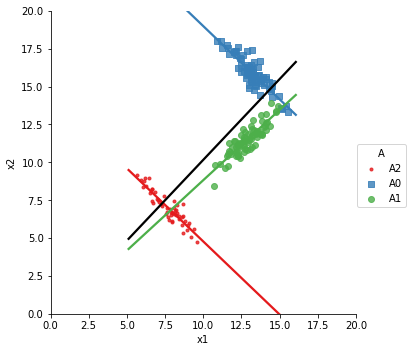

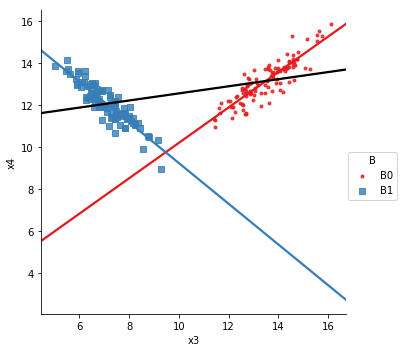

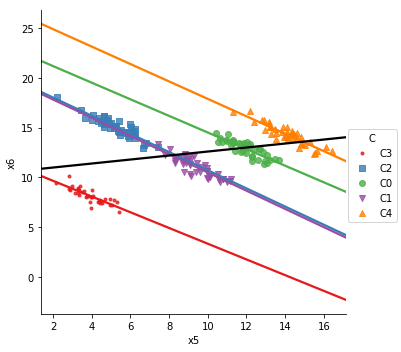

In [32]:
sp_plot(many_sp_df_diff,'x1','x2','A')
plt.axis(domain_range)
sp_plot(many_sp_df_diff,'x3','x4','B')
sp_plot(many_sp_df_diff,'x5','x6','C')


Next, we can apply our detection algorithm and mark which rows were designed in and which were not

In [4]:
many_sp_df_diff_result = dsp.mark_designed_rows(dsp.detect_simpsons_paradox(many_sp_df_diff),sp_design_list)
many_sp_df_diff_result.head() # we only need to see a little

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed
0,0.749148,x1,x2,-0.877622,A,A0,True
1,0.110993,x1,x3,-0.156688,A,A0,False
2,0.024972,x1,x4,-0.151552,A,A0,False
3,0.024972,x1,x4,-0.024495,A,A1,False
4,0.065424,x1,x5,-0.010026,A,A1,False


We see that in the first few rows therea re both designed and unintentional occurences, we can get the counts for earch here:

In [5]:
many_sp_df_diff_result['designed'].value_counts()

False    47
True      8
Name: designed, dtype: int64

We can look at the correlatiton coefficients first

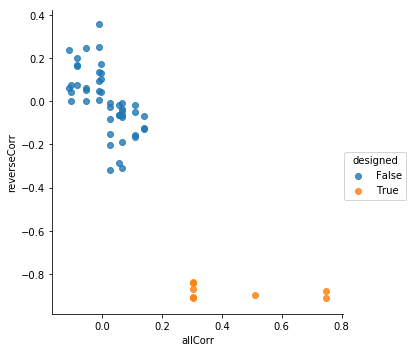

In [6]:

sns.lmplot('allCorr','reverseCorr',data=many_sp_df_diff_result, fit_reg=False,hue='designed')

This shows that the first thing we can to to filter/ improve is to rank by the correlation coefficients. WHile somem of these may be strong relationships that are just highly nonlinenar, this is a first pass filter to remove false relationships. 

In [7]:
many_sp_df_diff_result.groupby('designed')['allCorr'].describe()

,count,mean,std,min,25%,50%,75%,max
designed,,,,,,,,
False,47.0,0.011421,0.073094,-0.112572,-0.052755,0.024972,0.064660,0.140888
True,8.0,0.441023,0.203166,0.303790,0.303790,0.303790,0.570489,0.749148


Next we can look at angles between lines, we have functions for these added to the detect_simpsons_paradox module so and these will all add columns.  

In [9]:
results_df_slopes = dsp.add_slope_sp(many_sp_df_diff, many_sp_df_diff_result)
all_slopes_df = dsp.compute_slope_all(many_sp_df_diff, ['x' +str(i+1) for i in range(n_views*2)])
results_df_slopes = results_df_slopes.merge(all_slopes_df, left_on=['attr1','attr2'], right_on=['attr1','attr2'])
results_df_slopes['angle'] = results_df_slopes.apply(dsp.compute_angle,axis=1)
results_df_slopes.head()

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle
0,0.749148,x1,x2,-0.877622,A,A0,True,-0.966296,1.065931,90.845880
1,0.749148,x1,x2,-0.913721,A,A2,True,-0.964060,1.065931,90.779556
2,0.110993,x1,x3,-0.156688,A,A0,False,-0.529021,0.144875,36.123165
3,0.110993,x1,x3,-0.016624,B,B0,False,-0.007425,0.144875,8.668780
4,0.110993,x1,x3,-0.048457,B,B1,False,-0.015065,0.144875,9.106474


In [22]:
results_df_slopes.sort_values('angle',ascending=False)

,allCorr,attr1,attr2,reverseCorr,groupbyAttr,subgroup,designed,subgroup_slope,all_slope,angle
0,0.749148,x1,x2,-0.877622,A,A0,True,-0.966296,1.065931,90.845880
1,0.749148,x1,x2,-0.913721,A,A2,True,-0.964060,1.065931,90.779556
48,0.303790,x5,x6,-0.868316,C,C1,True,-0.915530,0.200807,53.829410
49,0.303790,x5,x6,-0.910533,C,C2,True,-0.912134,0.200807,53.723388
42,0.510937,x3,x4,-0.898550,B,B1,True,-0.969351,0.169182,53.710889
51,0.303790,x5,x6,-0.904953,C,C4,True,-0.875053,0.200807,52.542020
47,0.303790,x5,x6,-0.842855,C,C0,True,-0.833848,0.200807,51.177367
50,0.303790,x5,x6,-0.835599,C,C3,True,-0.789545,0.200807,49.647078
2,0.110993,x1,x3,-0.156688,A,A0,False,-0.529021,0.144875,36.123165
5,0.110993,x1,x3,-0.165251,C,C4,False,-0.242100,0.144875,21.852825


In [18]:
results_df_slopes.groupby('designed')['angle'].describe()

,count,mean,std,min,25%,50%,75%,max
designed,,,,,,,,
False,47.0,-0.336756,13.808717,-34.681489,-5.512365,0.823509,8.942691,36.123165
True,8.0,62.031949,17.822486,49.647078,52.200857,53.717139,63.066947,90.845880


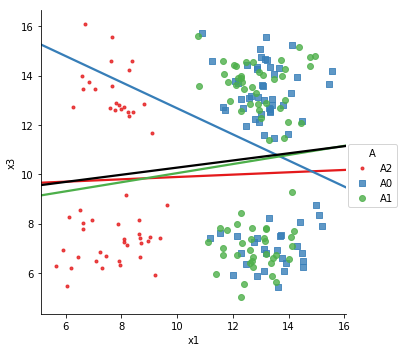

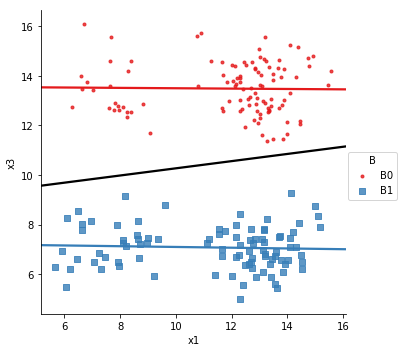

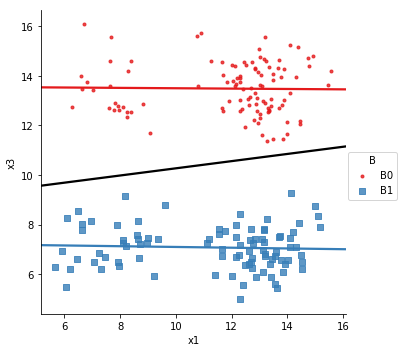

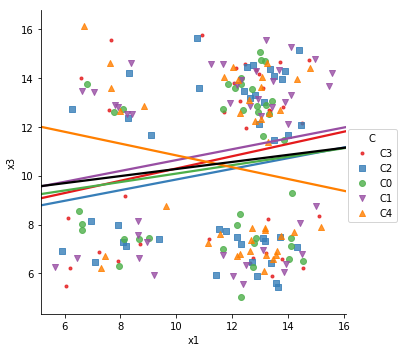

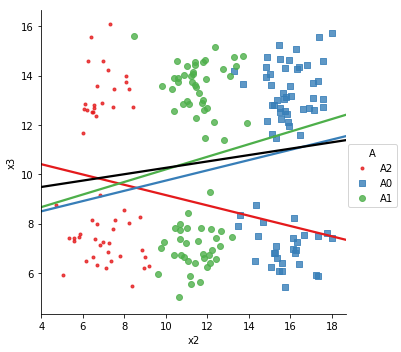

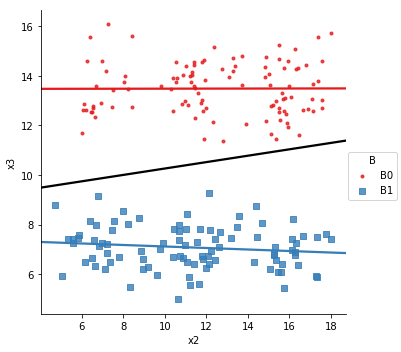

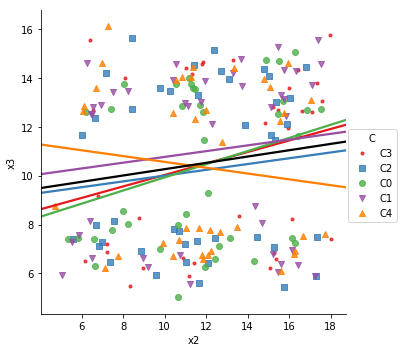

In [31]:

for row in results_df_slopes[['allCorr','attr1','attr2','groupbyAttr','designed']].values:
    if not row[4] and row[0] >.08:
        sp_plot(many_sp_df_diff,row[1],row[2],row[3])

In [ ]:
many_sp_df_diff.columns

Another way we might want to examine the subgroups is to see if the errors to the whole data set model orelate with class.  Ths is if the errors are hihgly deparable, thn 